# Update TextBlob Sentiment Lexicon

Given the absence of several relevant descriptors from the `textblob` sentiment lexicon, it is neccessary to update the lexicon with the missing terms.

The sentiment lexicon used by `textblob` can be found at `...site-packages\textblob\en\en-sentiment.xml`

The .xml file stores each word as an element with the following attributes:
* **form** - the token itself
* **wordnet_id** - WordNet3 lexical database ID number
* **pos** - Penn Treebank POS tag
* **sense** - indication of token usage
* **polarity** - (negative/positive, -1.0 to +1.0)
* **subjectivity** - (objective/subjective, +0.0 to +1.0)
* **confidence** - specifies if an adjective was hand-tagged (1.0) or inferred (0.7)

For the purposes of this project, it is sufficient to populate only **form** and **polarity**.

Additionally, simply assigning polarity scores of 1.0 (positive) and -1.0 (negative) will also suffice.

## Method
### 1. Create dictionaries of relevant attributes
- iterate through missing positive and negative descriptors
- create a dictionary for each descriptor containing relevant attributes for `sentiments.xml`.

In [1]:
import pandas as pd
negList=list(pd.read_csv("data/negList.csv")['Negative'])
posList=list(pd.read_csv("data/posList.csv")['Positive'])

df = pd.read_csv('data/tag_df.csv')

negWords = set(df[(df['sentiment']==0) & (df['description'].isin(negList))]['description'])
posWords = set(df[(df['sentiment']==0) & (df['description'].isin(posList))]['description'])

sen_dic = [{"form":word, "polarity":"1.0"} for word in posWords]
sen_dic.extend([{"form":word, "polarity":"-1.0"} for word in negWords])

### 2. Write new elements to sentiment.xml
- The [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html#module-xml.etree.ElementTree) module (Python global module) is used to access and write to `sentiment.xml`

```{warning}
It is advised to duplicate `sentiment.xml' before performing any modifications
```

In [2]:
import xml.etree.ElementTree as ET

# Read original textblob sentiment xml file
tree = ET.parse("C:/Users/rob_t/anaconda3/envs/steam_nlp/Lib/site-packages/textblob/en/en-sentiment_org.xml")
root = tree.getroot()

# Iterate new sentiment dictionary and append new elements to xml
for x,y in enumerate(sen_dic):
    elem = ET.Element("word",attrib=sen_dic[x])
    elem.tail = "\n"
    root.append(elem)

# write new snetiments.xml
tree.write("C:/Users/rob_t/anaconda3/envs/steam_nlp/Lib/site-packages/textblob/en/en-sentiment.xml")

### 3. Sentiment Scoring
- Sentiment polarity is re-assigned using updated sentiment lexicon

In [3]:
import numpy as np

# Overwrite df.sentiment with new scores
from textblob import TextBlob
df['sentiment'] = [TextBlob(x).sentiment.polarity for x in df['description']]

df['Sentiment1'] = np.select([(df['sentiment']>0),(df['sentiment']<0),(df['sentiment']==0)],['Positive','Negative','Neutral'])


## EDA

The sentiments lexicon is now updated. 

Comparing the distribution of sentiment classifications before and after modifying the sentiments lexicon illustrates the appropriate frequency changes.

A reduction in the frequency of neutral descriptors and an associated increase in positive/negative descriptors is apparent.

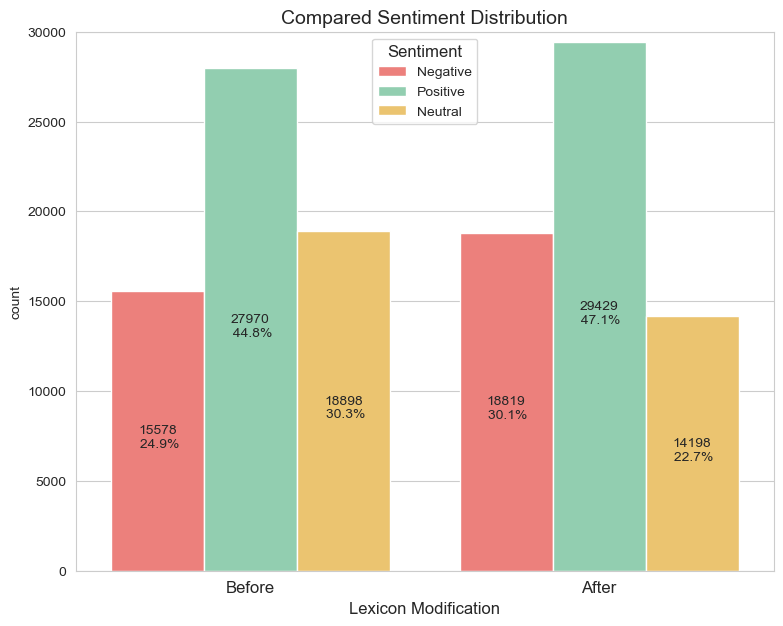

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(9,7))
ax=sns.countplot(
    data=pd.melt(df.loc[:,'Sentiment':]),
    hue="value",
    x="variable",
    hue_order=['Negative','Positive','Neutral'],
    palette=['#FF6F69','#88D8B0','#ffcc5c'],)
ax.set_xticklabels(['Before', 'After'], size=12)
ax.set_xlabel('Lexicon Modification', size=12)
ax.set_title("Compared Sentiment Distribution", size =14)
plt.legend(title='Sentiment', title_fontsize=12, loc='upper center')
plt.ylim(0,30000)

# create labels
for c in ax.containers:
    labels = [f'\n\n {h/df.Sentiment.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.bar_label(ax.containers[0], label_type='center')
ax.bar_label(ax.containers[1], label_type='center')
ax.bar_label(ax.containers[2], label_type='center');

In [5]:
# write to csv
df = df.loc[:,'aspect':'sentiment']
df.to_csv('data/tag_df_final.csv',index=False)